## CIFAR10 데이터셋을 가지고 연습해봅시다

In [1]:
%matplotlib inline

# A. logistic regression

## 0. from scratch

### data loading 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
from matplotlib import pyplot as plt
import numpy as np

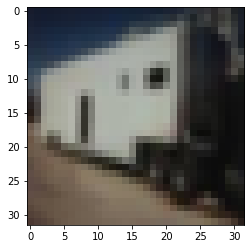

In [6]:
img = trainset.data[1201]
plt.imshow(img)

In [7]:
trainset.targets[17865]

0

### data preprocessing 

In [18]:
x_train, y_train, x_test, y_test  = map(torch.Tensor, (trainset.data, trainset.targets,
                                     testset.data, testset.targets))

In [58]:
# indexing의 자료형은 int형이여야 함. (when doing code from scratch)
# y_label의 nll loss를 구할 때 category가 int형이여야 함. (when using functional)
y_train = y_train.type(torch.int64)
y_test = y_test.type(torch.int64)

In [59]:
# n : number of data set
# h : height of image
# w : weight of image
# c : channel of image
n, h, w, c = x_train.shape
n_categories = int(y_train.max() - y_train.min() + 1)

In [60]:
x_train.shape

torch.Size([50000, 32, 32, 3])

In [61]:
import math 

nodes = h * w * c
weights = torch.randn(nodes, n_categories) / math.sqrt(nodes)

In [62]:
weights

tensor([[-0.0092,  0.0405,  0.0018,  ..., -0.0221, -0.0090,  0.0019],
        [ 0.0049, -0.0073, -0.0166,  ...,  0.0059, -0.0034,  0.0108],
        [-0.0033,  0.0146, -0.0130,  ..., -0.0055, -0.0159, -0.0052],
        ...,
        [-0.0260,  0.0039,  0.0108,  ...,  0.0087,  0.0257, -0.0214],
        [-0.0327,  0.0031, -0.0299,  ..., -0.0185,  0.0039, -0.0067],
        [-0.0276, -0.0132, -0.0347,  ..., -0.0036,  0.0206, -0.0163]])

In [63]:
print(weights.requires_grad)
weights.requires_grad_()
print(weights.requires_grad)

False
True


In [64]:
bias = torch.zeros(n_categories, requires_grad = True)

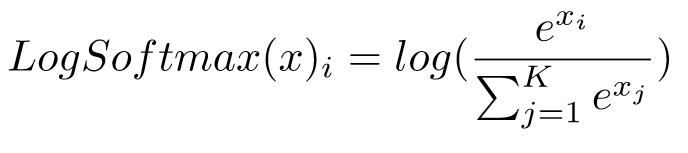

In [65]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # broadcasting
# berfore unsqueeze shape : (n, )
# after unsqueeze shape   : (n, 1) 

In [66]:
weights.exp().sum(-1).log().unsqueeze(-1).shape

torch.Size([3072, 1])

#### mnist data set과 달리 3차원이기 때문에 1차원으로 바꿔줌 : torch.flatten 함수

In [67]:
def preprocess(xb):
    return torch.flatten(xb, start_dim=1)

In [68]:
def model(xb):
    xb = preprocess(xb)
    return log_softmax(xb @ weights + bias)

In [69]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [70]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [71]:
lr = 0.5
epochs = 2

In [72]:
bs = 1000

In [73]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [74]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NegBackward>) tensor(0.0870)


## 1. torch.nn.functional 사용하기
loss function을 functional에서 가져와서 써줌. 

In [75]:
import torch.nn.functional as F

In [76]:
loss_func = F.cross_entropy

In [77]:
def model(xb):
    xb = preprocess(xb)
    return xb @ weights + bias

In [78]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        yb = yb.type(torch.int64) # indexing의 자료형은 int64여야함.
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [79]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NllLossBackward>) tensor(0.0870)


## 2. nn.Module을 사용해보기 
nn.Module을 상속하여 클래스를 만든다<br>
forward 단계에서 가중치, 절편, method를 유지하고, ``.parameters()``와 ``.zero_grad()`` 등을 가지고 있음<br>

In [80]:
from torch import nn

In [81]:
class CIFAR_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(nodes, n_categories) / math.sqrt(nodes))
        self.bias = nn.Parameter(torch.zeros(n_categories))
    
    def forward(self, xb):
        xb = preprocess(xb)
        return xb @ self.weights + self.bias

함수를 사용하는 대신에, 오브젝트를 사용함<br>
``nn.Module``오브젝트들은 마치 함수처럼 사용할 수 있다. 배후에서 PyTorch는 우리의 ``forward``함수를 자동으로 호출함

In [82]:
model = CIFAR_Logistic()

In [83]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

                
fit()

In [84]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(3007914.7500, grad_fn=<NllLossBackward>) tensor(0.1580)


## 3. nn.Linear를 사용해보기
weight, bias를 정의 및 초기화하고, ``xb @ weights + bias``를 계산하는 대신에 미리 정의된 선형 레이어로 ``nn.Linear``를 사용함

In [85]:
class CIFAR_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(nodes, n_categories)
        
    def forward(self, xb):
        return self.linear(preprocess(xb))

In [86]:
model = CIFAR_Logistic()
fit()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(6096789.5000, grad_fn=<NllLossBackward>) tensor(0.1650)


## 4. optim을 사용해보기 
매개변수를 수동으로 업데이트 하는 대신 옵티마이저의 ``step``메서드를 통해 업데이트 가능<br>
``optim.zero_grad()``는 기울기를 0으로 재설정해주어 다음 미니 배치의 기울기 계산 전에 호출해야 함

In [87]:
from torch import optim

In [88]:
def get_model():
    model = CIFAR_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [89]:
model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

tensor(124.8897, grad_fn=<NllLossBackward>)


## 5. Dataset을 사용해보기
x와 y를 묶어서 코드 한 줄에서 사용하기 용이<br>
이 전에는 x의 배치와 y와 배치를 따로 작성했다면 이번엔 한번에 인덱싱할 수 있음

In [90]:
from torch.utils.data import TensorDataset

In [91]:
train_ds = TensorDataset(x_train, y_train)

In [92]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(3923086.5000, grad_fn=<NllLossBackward>)


## 6. DataLoader를 사용해보기
``DataLoader``는 배치 관리를 담당하여 반복하기 쉽게 만들어 줌

In [93]:
from torch.utils.data import DataLoader

In [94]:
train_dl = DataLoader(train_ds, batch_size=bs)

In [95]:
model, opt = get_model()
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(3608351.5000, grad_fn=<NllLossBackward>)


## 7. test data추가하기

In [96]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_test, y_test)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [97]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(5059080.)
1 tensor(4492388.)


## 8. refactoring : fit(), get_data()

In [102]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [130]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [105]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [106]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 4347052.0
1 4387548.6


# B. CNN
사전에 정의된 ``nn.Conv2d``를 사용함<br>
Conv2D + ReLU + average pooling을 진행함

## 1. nn.Module + nn.Conv2d 

In [149]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1) # RGB channel 개수가 1->3 이어서 변경해줌
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, n_categories, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, c, w, h) # [1000, 32, 32, 3] -> [1000, 3, 32, 32]
        xb = F.relu(self.conv1(xb)) # [1000, 3, 32, 32] -> [1000, 16, 16, 16]
        xb = F.relu(self.conv2(xb)) # [1000, 16, 16, 16] -> [1000, 16, 8, 8]
        xb = F.relu(self.conv3(xb)) # [1000, 16, 8, 8] -> [1000, 10, 4, 4] 
        xb = F.avg_pool2d(xb, 4) # [1000, 10, 4, 4] -> [1000, 10, 1, 1]
        return xb.view(-1, xb.size(1))

In [150]:
model = CIFAR_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.302568197250366
1 2.302568197250366


## 2. nn.Sequential 사용해보기
``Sequential``을 사용하면 해당 객체에 포함된 각 모듈을 순차적으로 실행함<br>
이를 활용하려면 사용자정의 레이어를 정의해야 함

In [155]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, c, w, h)

In [157]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(c, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, n_categories, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4), # 입력 텐서 크기 
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.302568197250366
1 2.302568197250366


## 3. DataLoader 감싸기
preprocess를 모델에서 dataloader로 옮길 수 있습니다.

In [163]:
def preprocess(x, y):
    return x.view(-1, c, w, h), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [164]:
model = nn.Sequential(
    nn.Conv2d(c, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), # AdaptiveAvgPool2d는 출력텐서의 크기를 정의할 수 있음
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [165]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.3026352882385255
1 2.302568197250366
